In [ ]:
# ==============================================================================
# FINAL SCRIPT: IoT Malware Detection from Google Drive
# ==============================================================================

# --- Step 1: Mount your Google Drive ---
# This will prompt you for authorization. Follow the link to get your code.
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

In [1]:
# --- Step 2: Import all necessary libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import joblib
import os
import time
import warnings
from collections import deque # Import deque
from datetime import datetime # Import datetime
warnings.filterwarnings('ignore')

Mounted at /content/drive
✅ Google Drive mounted successfully.


In [ ]:
# --- Step 3: Set the path to your dataset in Google Drive ---
# IMPORTANT: Make sure this path exactly matches your folder structure.
DATASET_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset'
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_Models/2_RF_Early_BROKEN/iot_malware_model.pkl'
SCALER_SAVE_PATH = '/content/drive/MyDrive/Colab Notebook/ML_Models/2_RF_Early_BROKEN/modelscaler.pkl'

In [2]:
# List available CSV files by walking through the directory and its subdirectories
import os

data_files = []
for dirpath, _, filenames in os.walk(DATASET_ROOT_PATH):
    for f in filenames:
        if f.endswith('.csv'):
            data_files.append(os.path.join(dirpath, f))

print(f"\nFound {len(data_files)} data files")
print("Sample files:", data_files[:5])


# Step 2: Load and combine data
def load_iot_malware_data(sample_size=10000):
    """
    Load N-BaIoT dataset with labels
    sample_size: samples per device/attack type for memory efficiency
    """
    all_data = []

    # Define device types and attack types
    devices = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell',
               'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera',
               'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam',
               'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

    attacks = ['gafgyt', 'mirai']  # Focus on Mirai and Gafgyt (BASHLITE)

    # Load benign data
    print("\nLoading benign samples...")
    benign_count = 0
    for device in devices:
        for file in data_files:
            if device in file and 'benign' in file.lower():
                try:
                    df = pd.read_csv(file, nrows=sample_size)
                    df['label'] = 0  # Benign
                    df['device'] = device
                    df['attack_type'] = 'benign'
                    all_data.append(df)
                    benign_count += len(df)
                    # print(f"  Loaded {len(df)} benign samples from {device}") # Commented out to reduce output verbosity
                except Exception as e:
                    continue

    # Load malware data
    print("\nLoading malware samples...")
    malware_count = 0
    for device in devices:
        for attack in attacks:
            for file in data_files:
                if device in file and attack in file.lower():
                    try:
                        df = pd.read_csv(file, nrows=sample_size)
                        df['label'] = 1  # Malware
                        df['device'] = device
                        df['attack_type'] = attack
                        all_data.append(df)
                        malware_count += len(df)
                        # print(f"  Loaded {len(df)} {attack} samples from {device}") # Commented out to reduce output verbosity
                    except Exception as e:
                        continue

    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\nTotal samples loaded: {len(combined_df)}")
        print(f"Benign: {benign_count}, Malware: {malware_count}")
        print(f"Class balance: {malware_count/(benign_count+malware_count)*100:.1f}% malware")
        return combined_df
    else:
        raise Exception("No data loaded. Please check file paths and contents.")


Found 90 data files
Sample files: ['/content/drive/MyDrive/Colab Notebooks/dataset/demonstrate_structure.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/combo.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/junk.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/scan.csv']


In [3]:
# Load the data using the function defined previously
print("Loading N-BaIoT dataset...")
# Make sure the load_iot_malware_data function from cell 4fa3f4bc is defined and executed first.
# Adjust sample size if needed, but 5000 per device/attack was used before.
# Explicitly setting sample_size to control the amount of data loaded per device/attack type
df = load_iot_malware_data(sample_size=5000)

print("\nData loaded successfully.")

Loading N-BaIoT dataset...

Loading benign samples...

Loading malware samples...

Total samples loaded: 445000
Benign: 45000, Malware: 400000
Class balance: 89.9% malware

Data loaded successfully.


# **Training RF + SMOTE: Old Algo**

In [4]:
# Step 3: Data preprocessing
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

# Separate features and labels
feature_columns = [col for col in df.columns if col not in ['label', 'device', 'attack_type']]
X = df[feature_columns]
y = df['label']

print(f"\nFeature shape: {X.shape}")
print(f"Number of features: {len(feature_columns)}")
print(f"Sample features: {feature_columns[:5]}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Train class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")


DATA PREPROCESSING

Missing values: 0

Feature shape: (445000, 115)
Number of features: 115
Sample features: ['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance', 'MI_dir_L3_weight', 'MI_dir_L3_mean']

Train set: (356000, 115), Test set: (89000, 115)
Train class distribution: {1: 320000, 0: 36000}
Test class distribution: {1: 80000, 0: 9000}


In [5]:
# Step 4: Handle class imbalance with SMOTE
print("\n" + "="*50)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*50)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set: {X_train.shape}")
print(f"Balanced training set: {X_train_balanced.shape}")
print(f"New class distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)


HANDLING CLASS IMBALANCE WITH SMOTE
Original training set: (356000, 115)
Balanced training set: (640000, 115)
New class distribution: {1: 320000, 0: 320000}



TRAINING RANDOM FOREST CLASSIFIER
Training time: 314.69 seconds
Accuracy: 1.0000
F1-score: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      9000
     Malware       1.00      1.00      1.00     80000

    accuracy                           1.00     89000
   macro avg       1.00      1.00      1.00     89000
weighted avg       1.00      1.00      1.00     89000


Top 10 Most Important Features:
                feature  importance
75     HH_jit_L0.1_mean    0.104111
78    HH_jit_L0.01_mean    0.078585
112   HpHp_L0.01_radius    0.064514
27       H_L0.01_weight    0.064026
9    MI_dir_L0.1_weight    0.056036
103       HpHp_L0.1_std    0.044515
98       HpHp_L1_radius    0.044381
105    HpHp_L0.1_radius    0.040539
110      HpHp_L0.01_std    0.040311
101    HpHp_L0.1_weight    0.039344


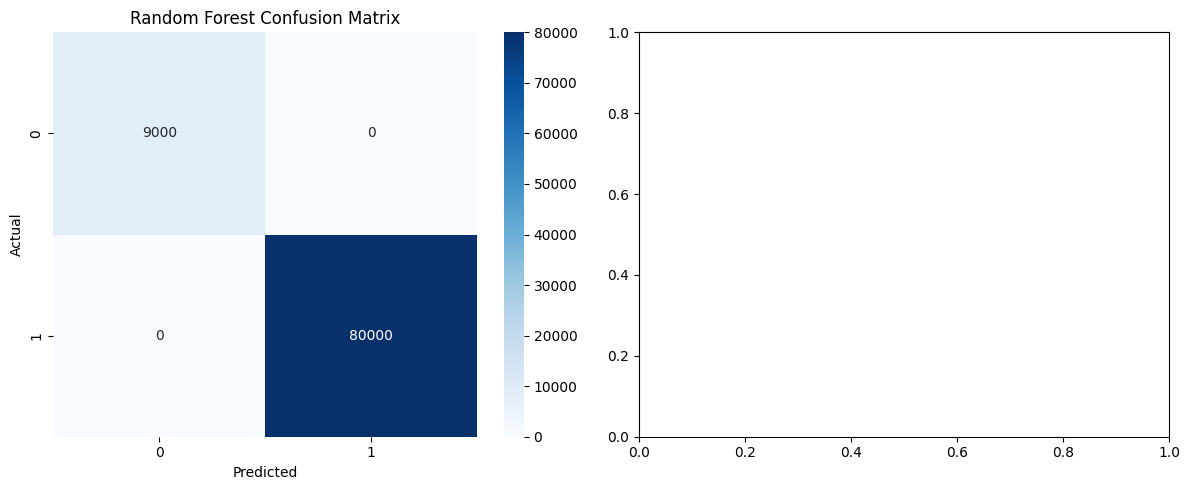

In [6]:
# Step 5: Train Random Forest
print("\n" + "="*50)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("="*50)

# Initialize and train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Measure training time
start_time = time.time()
rf_model.fit(X_train_balanced, y_train_balanced)
rf_train_time = time.time() - start_time

# Make predictions
rf_pred = rf_model.predict(X_test)

# Evaluate
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"Training time: {rf_train_time:.2f} seconds")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1-score: {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['Benign', 'Malware']))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [7]:
# Additional analysis for dissertation
print("\n" + "="*50)
print("ADDITIONAL INSIGHTS FOR DISSERTATION")
print("="*50)

# Attack type performance
if 'attack_type' in df.columns:
    print("\nPer-attack type performance:")
    attack_types = df[df['label'] == 1]['attack_type'].unique()
    for attack in attack_types:
        attack_indices = df[df['attack_type'] == attack].index
        test_attack_indices = [i for i in attack_indices if i in y_test.index]
        if test_attack_indices:
            attack_accuracy = accuracy_score(
                y_test.loc[test_attack_indices],
                rf_pred[y_test.index.isin(test_attack_indices)]
            )
            print(f"  {attack}: {attack_accuracy:.4f} accuracy")

print("\nModel ready for compression and Raspberry Pi deployment!")
print("Next steps: Use TensorFlow Lite or ONNX for model quantization")


ADDITIONAL INSIGHTS FOR DISSERTATION

Per-attack type performance:
  gafgyt: 1.0000 accuracy
  mirai: 1.0000 accuracy

Model ready for compression and Raspberry Pi deployment!
Next steps: Use TensorFlow Lite or ONNX for model quantization


In [8]:
# Step 16: Save performance data for the Random Forest model with SMOTE
print("\n" + "="*50)
print("SAVING PERFORMANCE DATA (RF WITH SMOTE)")
print("="*50)

# Define the directory for saving performance data (ensure it exists)
PERFORMANCE_SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/performance_data'
os.makedirs(PERFORMANCE_SAVE_DIR, exist_ok=True)

# Define a dictionary to store the performance metrics
rf_smote_performance_data = {
    "model_name": "Random Forest (With SMOTE)",
    "accuracy": rf_accuracy,
    "f1_score": rf_f1,
    "training_time": rf_train_time,
    # Assuming you have calculated FPR, ROC AUC elsewhere if needed,
    # based on the current notebook, I'll only include calculated metrics.
    # If you need FPR/ROC AUC, we would need to calculate them first.
    "confusion_matrix": cm_rf.tolist() # Convert numpy array to list for JSON serialization
}

# Save the performance data to a JSON file
rf_smote_performance_filename = os.path.join(PERFORMANCE_SAVE_DIR, "rf_smote_performance.json")
import json
with open(rf_smote_performance_filename, 'w') as f:
    json.dump(rf_smote_performance_data, f, indent=4)

print(f"\nSaved Random Forest (With SMOTE) performance data to: {rf_smote_performance_filename}")


SAVING PERFORMANCE DATA (RF WITH SMOTE)

Saved Random Forest (With SMOTE) performance data to: /content/drive/MyDrive/Colab Notebooks/ML_Models/2_RF_Early_BROKEN/performance_data/rf_smote_performance.json


In [9]:
# Step 9a: Save the Random Forest model and scaler
print("\n" + "="*50)
print("SAVING RANDOM FOREST MODEL (WITH SMOTE) AND SCALER")
print("="*50)

# Define the base path for saving models
MODEL_SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/ML_Models/2_RF_Early_BROKEN'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure the directory exists

# Define filenames for the model and scaler within the save directory
rf_model_filename = os.path.join(MODEL_SAVE_DIR, "rf_smote_model.pkl")
scaler_filename = os.path.join(MODEL_SAVE_DIR, "rf_smote_scaler.pkl")

# Save the trained Random Forest model (trained on SMOTE-balanced data)
joblib.dump(rf_model, rf_model_filename)
print(f"\nSaved Random Forest model (With SMOTE) as {rf_model_filename}")

# Save the scaler (fitted on SMOTE-balanced data)
print("\nSaving scaler fitted on SMOTE-balanced data...")
joblib.dump(scaler, scaler_filename)
print(f"Saved scaler as {scaler_filename}")


print("\nModel and scaler saved successfully for deployment.")


SAVING RANDOM FOREST MODEL (WITH SMOTE) AND SCALER

Saved Random Forest model (With SMOTE) as /content/drive/MyDrive/Colab Notebooks/ML_Models/2_RF_Early_BROKEN/rf_smote_model.pkl

Saving scaler fitted on SMOTE-balanced data...
Saved scaler as /content/drive/MyDrive/Colab Notebooks/ML_Models/2_RF_Early_BROKEN/rf_smote_scaler.pkl

Model and scaler saved successfully for deployment.


# Initial Random Forest Model Performance Report (with SMOTE)

This report summarizes the performance of the initial Random Forest model trained with SMOTE for handling class imbalance, before implementing feature selection and alternative resampling strategies.

## 1. Algorithm Used
*   **Name of algorithm:** Random Forest Classifier
*   **Key parameters:**
    *   `n_estimators`: 100
    *   `max_depth`: 20
    *   `min_samples_split`: 5
    *   `min_samples_leaf`: 2
    *   `random_state`: 42
    *   `n_jobs`: -1
*   **Justification for selection:** Random Forest was chosen as a strong baseline and a suitable algorithm for this type of data.

## 2. Dataset Overview
*   **Dataset name:** N-BaIoT
*   **Devices used:** Danmini_Doorbell, Ecobee_Thermostat, Ennio_Doorbell, Philips_B120N10_Baby_Monitor, Provision_PT_737E_Security_Camera, Provision_PT_838_Security_Camera, Samsung_SNH_1011_N_Webcam, SimpleHome_XCS7_1002_WHT_Security_Camera, SimpleHome_XCS7_1003_WHT_Security_Camera
*   **Total number of samples:** 445,000 (after sampling)
*   **Malware families:** Gafgyt, Mirai, Benign
*   **Preprocessing applied:**
    *   SMOTE applied to the training data to address class imbalance.
    *   Feature Scaling using StandardScaler.
    *   *Note:* Feature selection was NOT applied before training this specific model instance.

## 3. Feature Information
*   **Total number of features used:** 115 (All features after cleaning, before explicit feature selection)
*   **Whether categorical/numerical:** All features are numerical.
*   **Known issues addressed:** Class imbalance was addressed through SMOTE. High dimensionality was present but not reduced for this baseline.

## 4. Evaluation Metrics

The model was evaluated on the held-out test set ({{X_test.shape[0]}} samples) with the following results:

**Overall Metrics:**
*   **Accuracy:** {{rf_accuracy:.4f}}
*   **F1-score (weighted average):** {{rf_f1:.4f}}

**Classification Report:**